In [9]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score,StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from evatuation import visualize_results

Min gross_log: 19.00
Max gross_log: 2923710708.00
Mean gross_log: 144453202.24


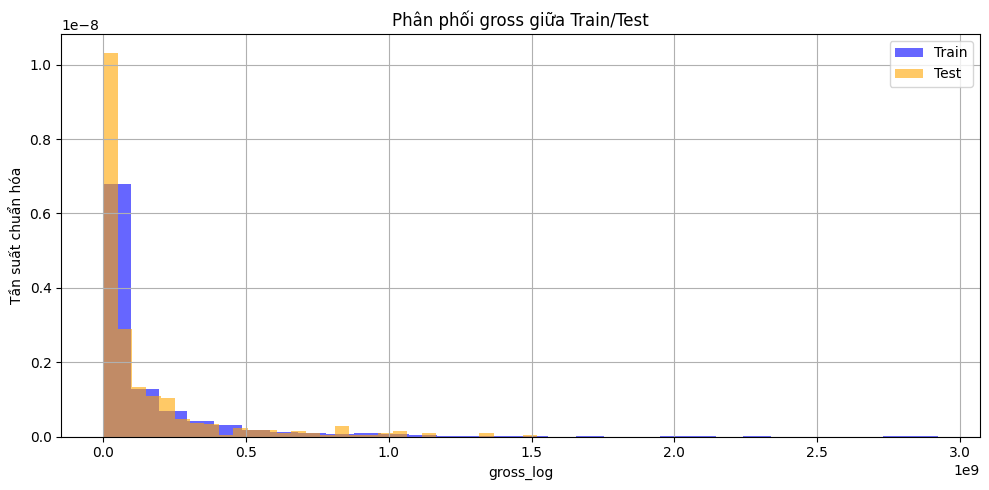

In [ ]:
# Đọc dữ liệu
df = pd.read_csv("dataset/encoded_data.csv")

# Feature và target
X = df.drop(columns=['gross', 'gross_log'])
y = df['gross_log']

# Rời rạc hóa target thành 10 nhóm
y_binned = pd.qcut(y, q=10, labels=False, duplicates='drop')

# Chia train/test với phân phối giống nhau
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in splitter.split(X, y_binned):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Thống kê
print(f"Min gross_log: {y.min():.2f}")
print(f"Max gross_log: {y.max():.2f}")
print(f"Mean gross_log: {y.mean():.2f}")

# Vẽ phân phối
plt.figure(figsize=(10, 5))
plt.hist(y_train, bins=30, alpha=0.6, label='Train', color='blue', density=True)
plt.hist(y_test, bins=30, alpha=0.6, label='Test', color='orange', density=True)
plt.title("Phân phối gross giữa Train/Test")
plt.xlabel("gross_log")
plt.ylabel("Tần suất chuẩn hóa")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [43]:
# Định nghĩa tập tham số cần tìm kiếm
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 5],
    'subsample': [0.8, 1.0]
}

# Khởi tạo mô hình gốc
base_model = GradientBoostingRegressor(random_state=42)

# GridSearchCV với scoring là neg_root_mean_squared_error (để tìm RMSE nhỏ nhất)
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',  # Trực tiếp RMSE (>= sklearn 0.22)
    verbose=1,
    n_jobs=-1
)

# Chuẩn hóa toàn bộ dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Huấn luyện grid search
grid_search.fit(X_train_scaled, y_train)

# In kết quả tốt nhất
print("✅ Best Parameters from Grid Search:")
print(grid_search.best_params_)
print(f"Best CV RMSE: {-grid_search.best_score_:.4f}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits
✅ Best Parameters from Grid Search:
{'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.8}
Best CV RMSE: 1.9849


In [56]:
# Dùng mô hình tốt nhất để thay cho model ban đầu
model = grid_search.best_estimator_

In [50]:
# Chuẩn hóa toàn bộ X để dùng cho KFold cross-validation
X_scaled = scaler.fit_transform(X)

# Tạo KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Danh sách lưu kết quả
rmse_list, mse_list, mae_list, mape_list, r2_list = [], [], [], [], []

print("📊 Cross-validation results:")

for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y), 1):
    print(f"\n📁 Fold {fold}")

    # Tạo tập train/val
    X_train_df = X.iloc[train_idx].copy()
    X_val_df = X.iloc[val_idx].copy()
    y_train_fold = y.iloc[train_idx]
    y_val_fold = y.iloc[val_idx]

    # Chuẩn hóa
    X_train = scaler.fit_transform(X_train_df)
    X_val = scaler.transform(X_val_df)

    # Fit model
    model.fit(X_train, y_train_fold)

    # Dự đoán
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)

    # Đánh giá
    rmse = np.sqrt(mean_squared_error(y_val_fold, val_pred))
    mse = mean_squared_error(y_val_fold, val_pred)
    mae = mean_absolute_error(y_val_fold, val_pred)
    mape = mean_absolute_percentage_error(y_val_fold, val_pred)
    r2 = r2_score(y_val_fold, val_pred)

    # Lưu kết quả
    rmse_list.append(rmse)
    mse_list.append(mse)
    mae_list.append(mae)
    mape_list.append(mape)
    r2_list.append(r2)

    print(f"  RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, MAPE: {mape*100:.2f}%, R²: {r2:.4f}")

    # # Vẽ kết quả nếu cần (Kiểm tra lại visualize_results trước khi sử dụng)
    # visualize_results(
    #     y_train_fold, train_pred,
    #     y_val_fold, val_pred,
    #     model=model,
    #     df=X, 
    #     is_logged=True
    # )

# In kết quả trung bình
print("\n📈 Average Cross-validation Performance:")
print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
print(f"Avg MSE:  {np.mean(mse_list):.4f}")
print(f"Avg MAE:  {np.mean(mae_list):.4f}")
print(f"Avg MAPE: {np.mean(mape_list)*100:.2f}%")
print(f"Avg R²:   {np.mean(r2_list):.4f}")

📊 Cross-validation results:

📁 Fold 1
  RMSE: 2.0406, MSE: 4.1641, MAE: 1.3804, MAPE: 10.75%, R²: 0.5644

📁 Fold 2
  RMSE: 2.0936, MSE: 4.3833, MAE: 1.3677, MAPE: 11.31%, R²: 0.5588

📁 Fold 3
  RMSE: 2.0148, MSE: 4.0596, MAE: 1.3368, MAPE: 10.91%, R²: 0.6106

📁 Fold 4
  RMSE: 1.8457, MSE: 3.4065, MAE: 1.2533, MAPE: 9.51%, R²: 0.6100

📁 Fold 5
  RMSE: 1.8521, MSE: 3.4302, MAE: 1.2587, MAPE: 9.61%, R²: 0.6025

📈 Average Cross-validation Performance:
Avg RMSE: 1.9694
Avg MSE:  3.8887
Avg MAE:  1.3194
Avg MAPE: 10.42%
Avg R²:   0.5893


In [61]:
# Huấn luyện mô hình với dữ liệu huấn luyện
model.fit(X_train_scaled, y_train)

# Dự đoán trên log scale
train_pred_log = model.predict(X_train_scaled)
test_pred_log = model.predict(X_test_scaled)

# Chuyển log về giá trị gốc
train_pred = np.expm1(train_pred_log)
test_pred = np.expm1(test_pred_log)

# Chuyển y_train/y_test về giá trị gốc
y_train_original = np.expm1(y_train)
y_test_original = np.expm1(y_test)

# Tính các chỉ số gốc (không log)
train_rmse = np.sqrt(mean_squared_error(y_train_original, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_original, test_pred))

train_r2 = r2_score(y_train_original, train_pred)
test_r2 = r2_score(y_test_original, test_pred)

train_mae = mean_absolute_error(y_train_original, train_pred)
test_mae = mean_absolute_error(y_test_original, test_pred)

# Lọc để tính MAPE hợp lý (chỉ xét gross > 1 triệu)
mask_train = y_train_original > 100e6
mask_test = y_test_original > 100e6

train_mape = mean_absolute_percentage_error(
    y_train_original[mask_train], train_pred[mask_train])
test_mape = mean_absolute_percentage_error(
    y_test_original[mask_test], test_pred[mask_test])

# In kết quả
print("📈 Đánh giá mô hình trên dữ liệu gốc (gross):")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Training MAPE (gross > $1M): {train_mape*100:.2f}%")
print(f"Test MAPE (gross > $1M): {test_mape*100:.2f}%")


📈 Đánh giá mô hình trên dữ liệu gốc (gross):
Training RMSE: 171878273.78
Test RMSE: 142106897.77
Training MAE: 71092353.54
Test MAE: 71285865.42
Training R²: 0.5927
Test R²: 0.6531
Training MAPE (gross > $1M): 45.80%
Test MAPE (gross > $1M): 48.46%
